In [21]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
import cv2
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
df = pd.read_csv("train_set.csv")

In [23]:
df["label"].value_counts()

label
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: count, dtype: int64

In [24]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\data\\data\\images\\train"
TEST_PATH = ROOT_PATH + "\\data\\data\\images\\test"
filenames_train = os.listdir(TRAIN_PATH)
filenames_test = os.listdir(TEST_PATH)

IMAGE_WIDTH=48
IMAGE_HEIGHT=48
IMAGE_CHANNELS=1
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 50
earlystop = EarlyStopping(patience=5)
mcheckpoint = ModelCheckpoint("ej_paisaje.h5")
label_encoder = LabelEncoder()

In [25]:
print(ROOT_PATH)
print(TRAIN_PATH)
print(filenames_train)

c:\Users\adria\Desktop\emociones
c:\Users\adria\Desktop\emociones\data\data\images\train
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [53]:
def read_data(path, archivos, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for i in archivos:
        current_path = os.path.join(path, i)

        for j in os.listdir(current_path):
            image_path = os.path.join(current_path, j)
            #print(image_path)
            # Leer la imagen y aplicarle el resize
            image = imread(image_path, 0)
            smallimage = cv2.resize(image, (im_size, im_size))
            # Guardo en X
            X.append(smallimage)
            Y.append(i)
            

        
    
    return np.array(X),Y

X_train, y_train = read_data(TRAIN_PATH, filenames_train, IMAGE_WIDTH)
X_test, y_test = read_data(TEST_PATH, filenames_test, IMAGE_WIDTH)

print(X_train.shape)
print(X_test.shape)

(28821, 48, 48)
(7066, 48, 48)


(48, 48)


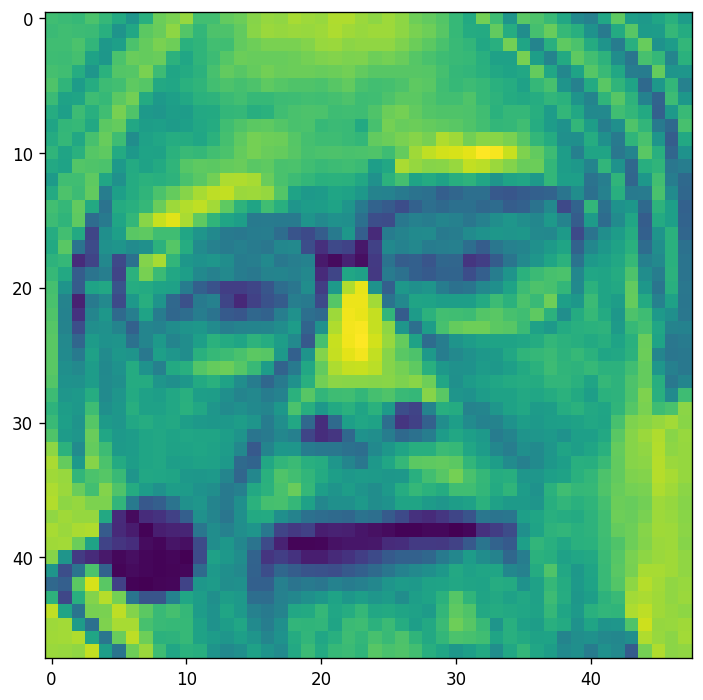

In [57]:
print(X_train[1].shape)
plt.imshow(X_train[1]);

In [58]:
y_train = label_encoder.fit_transform(y_train)
y_train = np.array(y_train)
print(y_train.max())

6


In [59]:
y_test = label_encoder.fit_transform(y_test)
y_test = np.array(y_test)

In [60]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [61]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [62]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


In [63]:
print(X_train.shape)
print(y_train.shape)

(28821, 48, 48)
(28821,)


In [64]:
X_train = np.expand_dims(X_train, -1) #redimensiona el array para poder usarlo en el modelo
X_test = np.expand_dims(X_test, -1)

In [65]:
print(X_train.shape)
print(y_train.shape)

(28821, 48, 48, 1)
(28821,)


In [77]:
layers = [
    keras.layers.Conv2D(48, (3,3), activation='relu', input_shape=IMAGE_SIZE), #como tiene el input_shape es la de entrada
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax') #sigmoid es para binario, para multiclase
]


model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_6 (Conv2D)           (None, 46, 46, 48)        480       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 23, 23, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 128)       55424     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               1638528   
                                                                 
 dense_7 (Dense)             (None, 7)                 903       
          

In [74]:
print(X_train.shape)
print(y_train.shape)

(28821, 48, 48, 1)
(28821,)


In [79]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2)

Epoch 1/50
721/721 [==============================] - 49s 67ms/step - loss: 1.3918 - accuracy: 0.4534 - val_loss: 7.2531 - val_accuracy: 0.0088
Epoch 2/50
  1/721 [..............................] - ETA: 43s - loss: 1.1414 - accuracy: 0.5312

c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


721/721 [==============================] - 48s 66ms/step - loss: 1.2225 - accuracy: 0.5247 - val_loss: 7.8693 - val_accuracy: 0.0094
Epoch 3/50
721/721 [==============================] - 46s 64ms/step - loss: 1.1006 - accuracy: 0.5786 - val_loss: 8.6413 - val_accuracy: 0.0309
Epoch 4/50
721/721 [==============================] - 45s 63ms/step - loss: 0.9967 - accuracy: 0.6192 - val_loss: 8.8933 - val_accuracy: 0.0642
Epoch 5/50
721/721 [==============================] - 47s 66ms/step - loss: 0.8711 - accuracy: 0.6714 - val_loss: 9.6557 - val_accuracy: 0.0536
Epoch 6/50
721/721 [==============================] - 45s 63ms/step - loss: 0.7408 - accuracy: 0.7228 - val_loss: 11.6824 - val_accuracy: 0.0664
